# Variational Autoencoders

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem.

In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result. 

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

This expression applies to two univariate Gaussian distributions (the full expression for two arbitrary univariate Gaussians is derived in [this math.stackexchange post](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)). Extending it to our diagonal Gaussian distributions is not difficult; we simply sum the KL divergence for each dimension.

This loss is useful for two reasons. First, we cannot train the encoder network by gradient descent without it, since gradients cannot flow through sampling (which is a non-differentiable operation). Second, by penalizing the KL divergence in this manner, we can encourage the latent vectors to occupy a more centralized and uniform location. In essence, we force the encoder to find latent vectors that approximately follow a standard Gaussian distribution that the decoder can then effectively decode.

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import torch
from torch.autograd import Function

class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]


In [4]:
class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [5]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

In [6]:
class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codebook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
#         print(z_q_x_st.size())
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x


The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [7]:
from torchvision import transforms

threshold = 0.5  # Set a threshold. Values above this threshold will be set to 1, otherwise to 0.

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to whatever size you need. Adjust this!
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
#     transforms.Lambda(lambda x: (x > threshold).float())  # Binarize the image
])


In [8]:
latent_dims = 2

# data = torch.utils.data.DataLoader(
#         torchvision.datasets.MNIST('./data',                     
# #                transform=transform, 
#                 transform=torchvision.transforms.ToTensor(), 
#                download=True),
#         batch_size=128,
#         shuffle=True)

data = DataLoader(
    datasets.ImageFolder(root='OpenCamera-20230916T191614Z-001\OpenCamera', transform=transform),
#     datasets.ImageFolder(root='bg_sub', transform=transform),
    batch_size=200,
    shuffle=True
)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

In [9]:
from tqdm import tqdm
def train(model, data_loader, epochs=50, initial_lr=0.001, decay_step=10, decay_gamma=0.5):
    opt = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=decay_step, gamma=decay_gamma)
    
    for epoch in range(epochs):
        # Initializing the progress bar
        epoch_progress = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{epochs}", position=0, leave=True)
        for images, _ in epoch_progress:
            images = images.to(device)

            opt.zero_grad()
            x_tilde, z_e_x, z_q_x = model(images)

            # Reconstruction loss
            loss_recons = F.mse_loss(x_tilde, images)
            # Vector quantization objective
            loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
            # Commitment objective
            loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

            loss = loss_recons + loss_vq + 1 * loss_commit
            loss.backward()


            opt.step()
            # Update the progress bar description
            epoch_progress.set_postfix(loss=loss.item())
    
        # Step the scheduler to decrease the learning rate
        scheduler.step()
    return model

In [47]:
# vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = VectorQuantizedVAE(1, 64, 512).to(device)
vae = train(vae, data)

Epoch 50/50: 100%|██████████| 4/4 [00:27<00:00,  6.82s/it, loss=1.25]


In [55]:
import pickle
with open('vae-model_grey_normalize.pickle','wb') as fp:
    pickle.dump(vae,fp)

In [10]:
import pickle
vae = VectorQuantizedVAE(1, 64, 512).to(device)
file = open('vae-model_grey_normalize.pickle', 'rb')
vae = pickle.load(file)
# print(type(vae.state_dict()))
# vae.state_dict().update(data_temp)

In [11]:
def tensor_to_np_img(tensor_image):
    # Ensure the tensor is on the CPU and detached from computation graph
    numpy_image = tensor_image.to('cpu').detach().numpy()
    
    # Check if it's grayscale and adjust the shape if needed
    if numpy_image.shape[1] == 1:  # Grayscale has 1 channel
        numpy_image = np.squeeze(numpy_image, axis=1)
    
    # Convert from channel-first (C, H, W) to channel-last (H, W) format
    return numpy_image

In [94]:
for i, (x_batch, _) in enumerate(data):
    if x_batch.size(0) != data.batch_size:
        continue  # Skip batches that aren't of the specified batch size

    z, z_e_x, z_q_x = vae(x_batch.to(device))
    
    x_np = tensor_to_np_img(x_batch)
    z_np = tensor_to_np_img(z)

    mse_list = F.mse_loss(z, x_batch.to(device), reduction='none').mean([1, 2, 3]).tolist()


    for j in range(data.batch_size):
        # Create a new figure for each image pair
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Display original image (x)
        axes[0].imshow(x_np[j], cmap='gray')
        axes[0].axis('off')
        axes[0].set_title(f'Original {i*data.batch_size + j + 1}')

        # Display output image (z)
        axes[1].imshow(z_np[j], cmap='gray')
        axes[1].axis('off')
        axes[1].set_title(f'Reconstructed {i*data.batch_size + j + 1}')
        axes[1].set_xlabel(f'MSE: {mse_list[j]:.4f}', fontsize=10)
         # Display the MSE directly on the image
        axes[1].text(0.5, 0.95, f'MSE: {mse_list[j]:.4f}', 
                     transform=axes[1].transAxes, fontsize=10, 
                     color='red', ha='center', va='top', backgroundcolor='white')


        # Save the figure
        plt.tight_layout()
        plt.savefig(f"vae_output/vae_output_image_{i*data.batch_size + j + 1}.png")
        plt.close(fig)  # Close the figure to free up memory


Reconstruction Loss for batch 0, image 0: 0.0060492753982543945
Reconstruction Loss for batch 0, image 1: 0.00784975104033947
Reconstruction Loss for batch 0, image 2: 0.004898848943412304
Reconstruction Loss for batch 0, image 3: 0.026146961376070976
Reconstruction Loss for batch 0, image 4: 0.011055490002036095
Reconstruction Loss for batch 0, image 5: 0.007059549912810326
Reconstruction Loss for batch 0, image 6: 0.003936251625418663
Reconstruction Loss for batch 0, image 7: 0.0052571953274309635
Reconstruction Loss for batch 0, image 8: 0.007962685078382492
Reconstruction Loss for batch 0, image 9: 0.008311591111123562
Reconstruction Loss for batch 0, image 10: 0.01051015593111515
Reconstruction Loss for batch 0, image 11: 0.007963178679347038
Reconstruction Loss for batch 0, image 12: 0.008777987211942673
Reconstruction Loss for batch 0, image 13: 0.004853233695030212
Reconstruction Loss for batch 0, image 14: 0.008694482035934925
Reconstruction Loss for batch 0, image 15: 0.00749

KeyboardInterrupt: 

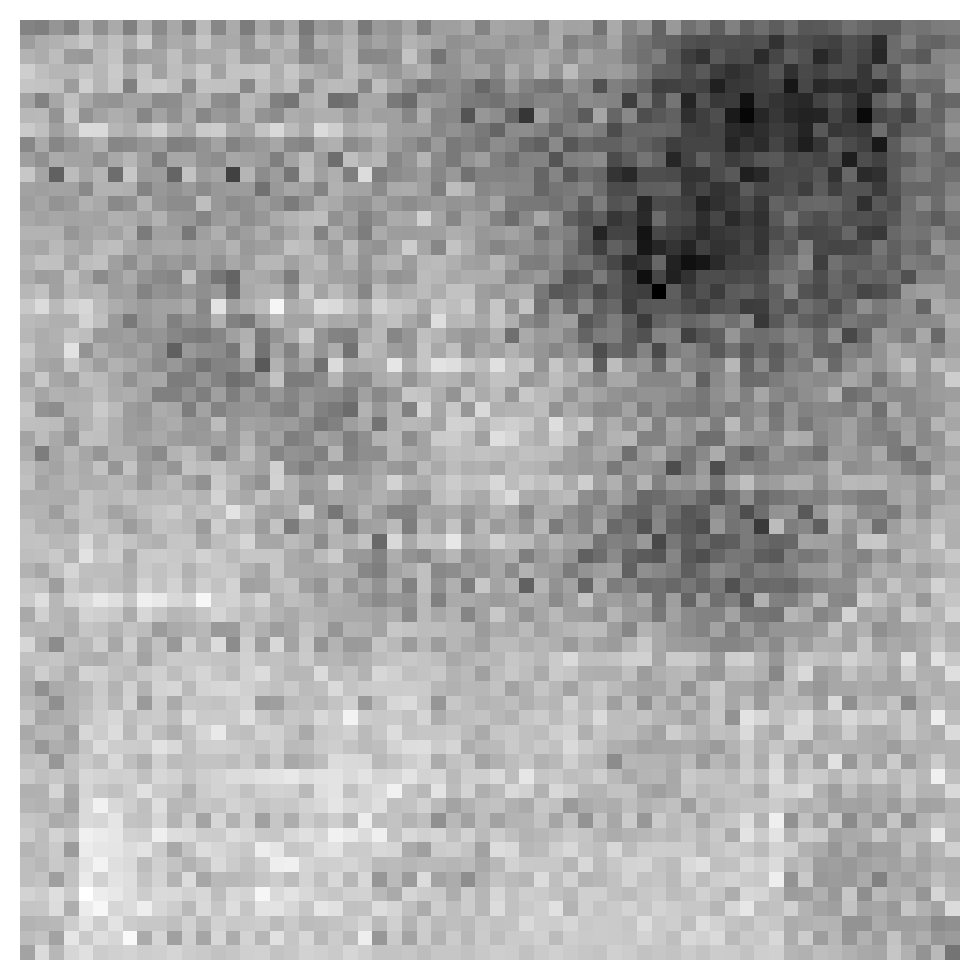

In [54]:
vae.eval()
K = 512
H, W = 64, 64

for i, batch in enumerate(data):
    batch_size = batch[0].shape[0]  # Get the size of the batch
    for j in range(batch_size):  # Iterate over each image in the batch
        x = batch[0][j:j+1].to(device)  # Take one image from the batch

        z, z_e_x, z_q_x = vae(x)

        latent_indices = vae.codebook(z_e_x)
        noise_factor = 1  # Adjust as needed for more or less noise
        noisy_latent_indices = latent_indices + torch.randint(-noise_factor, noise_factor + 1, size=latent_indices.size()).to(device)
        noisy_latent_indices = torch.clamp(noisy_latent_indices, 0, K-1)  # Make sure indices are valid

        generated_image = vae.decode(noisy_latent_indices).detach()

        # Convert to numpy for visualization
        generated_image_np = generated_image.cpu().numpy().squeeze()
        
        if len(generated_image_np.shape) == 3:  # If the image has channels dimension
            generated_image_np = generated_image_np.transpose(1, 2, 0)
        
        # Visualization and saving
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(generated_image_np, cmap='gray')  # use np.squeeze in case the images are grayscale
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(f'vae_output/generated/vqvae_generated_image_close_to_x_batch_{i}_img_{j}.png')
        plt.close(fig)  # Close the figure to free up memory

    if i == 25:  # Limit to the first 25 batches
        break




# latent_indices = torch.randint(0, K, (n_samples, H, W)).to(device)

# generated_images = vae.decode(latent_indices).detach()

# generated_images_np = generated_images.cpu().numpy().transpose(0, 2, 3, 1)

# fig, axes = plt.subplots(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), figsize=(15, 15))

# for ax, img in zip(axes.ravel(), generated_images_np):
#     ax.imshow(np.squeeze(img), cmap='gray') 
#     ax.axis('off')

# plt.tight_layout()
# plt.savefig('vqvae_generated_images.png')
# plt.show()

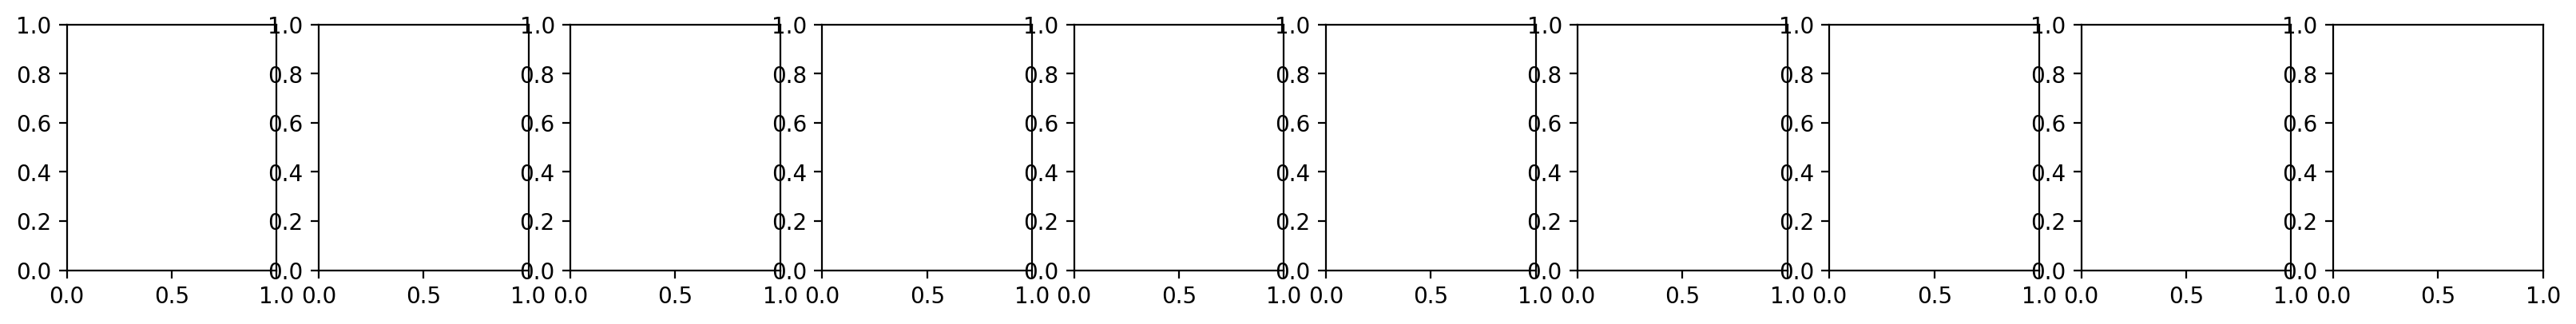

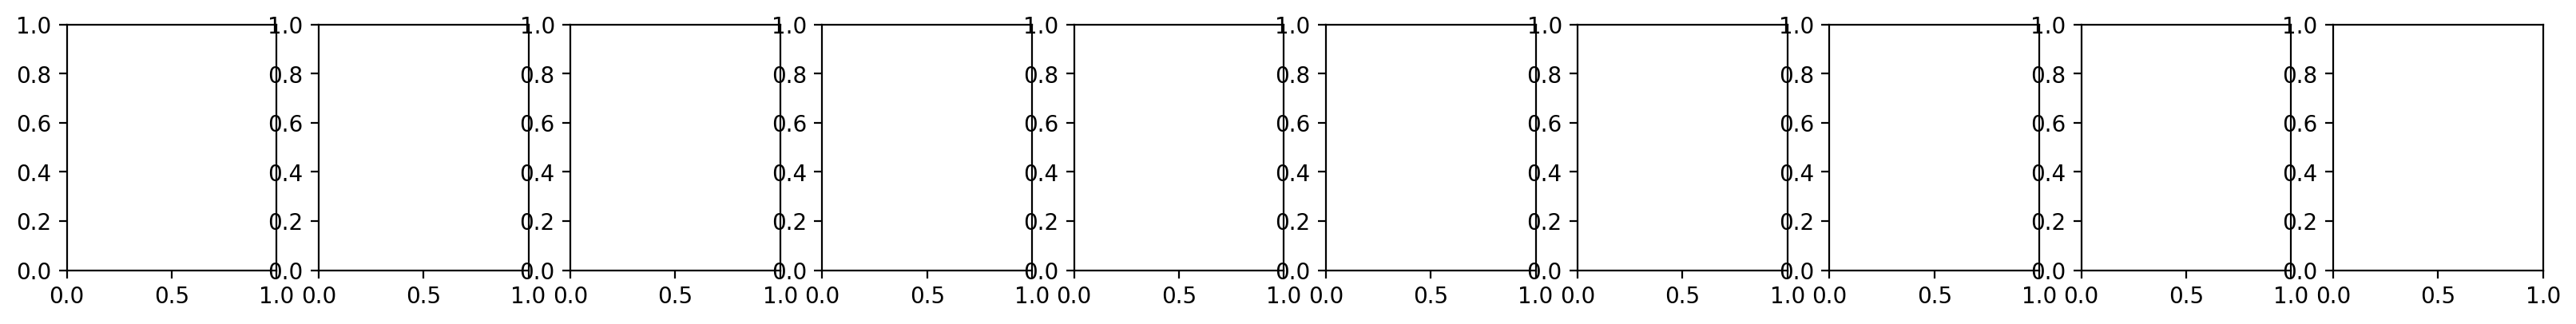

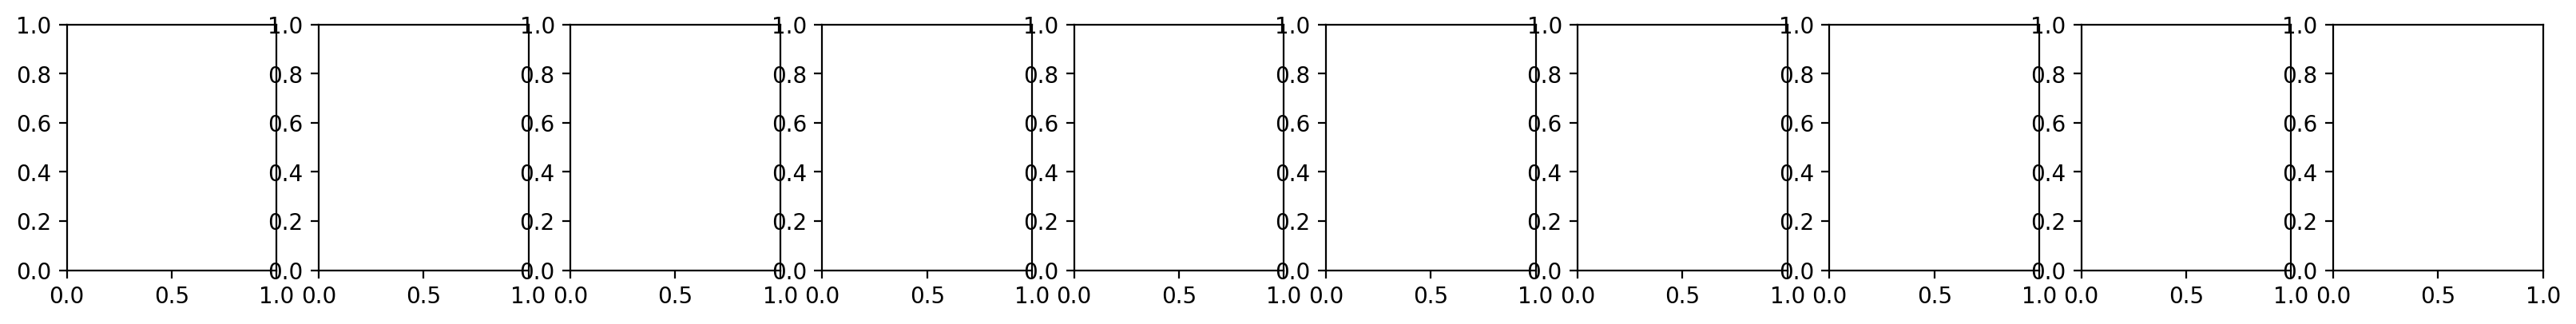

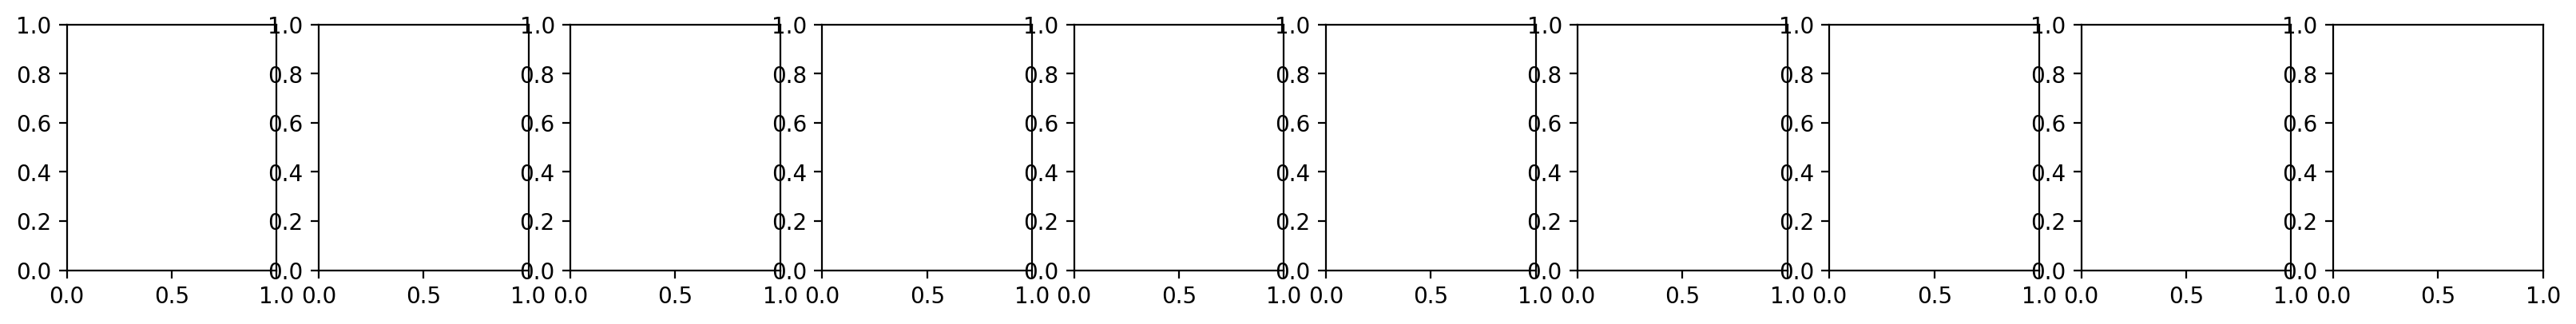

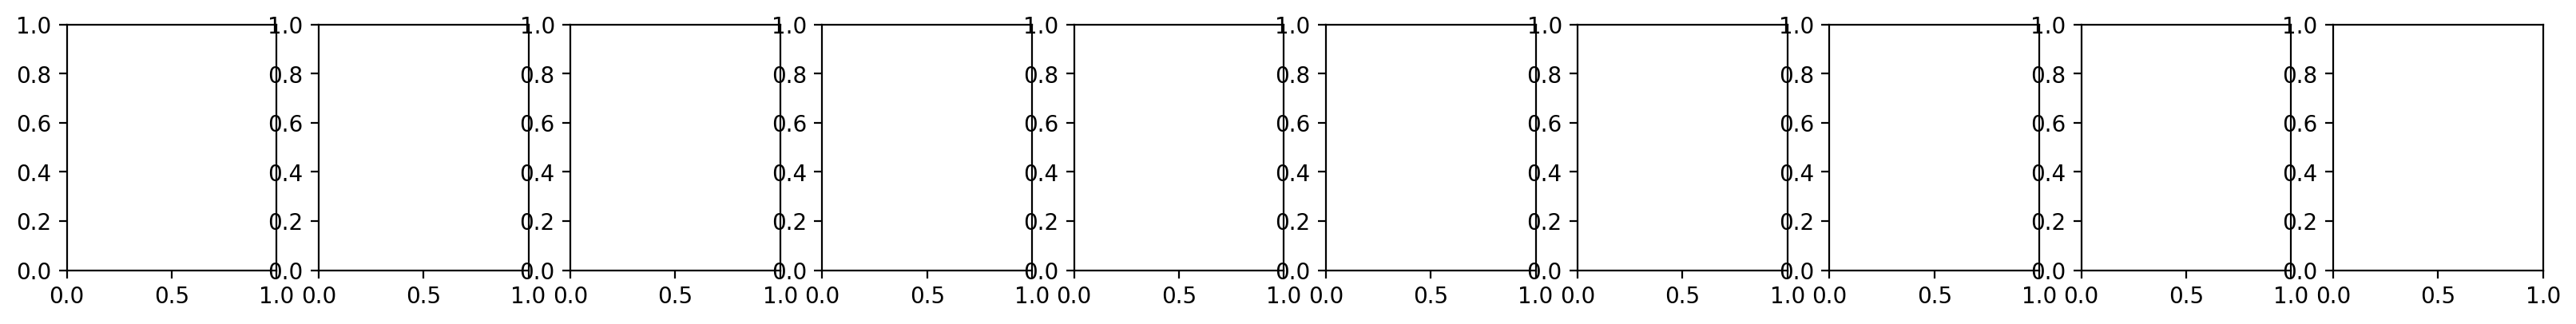

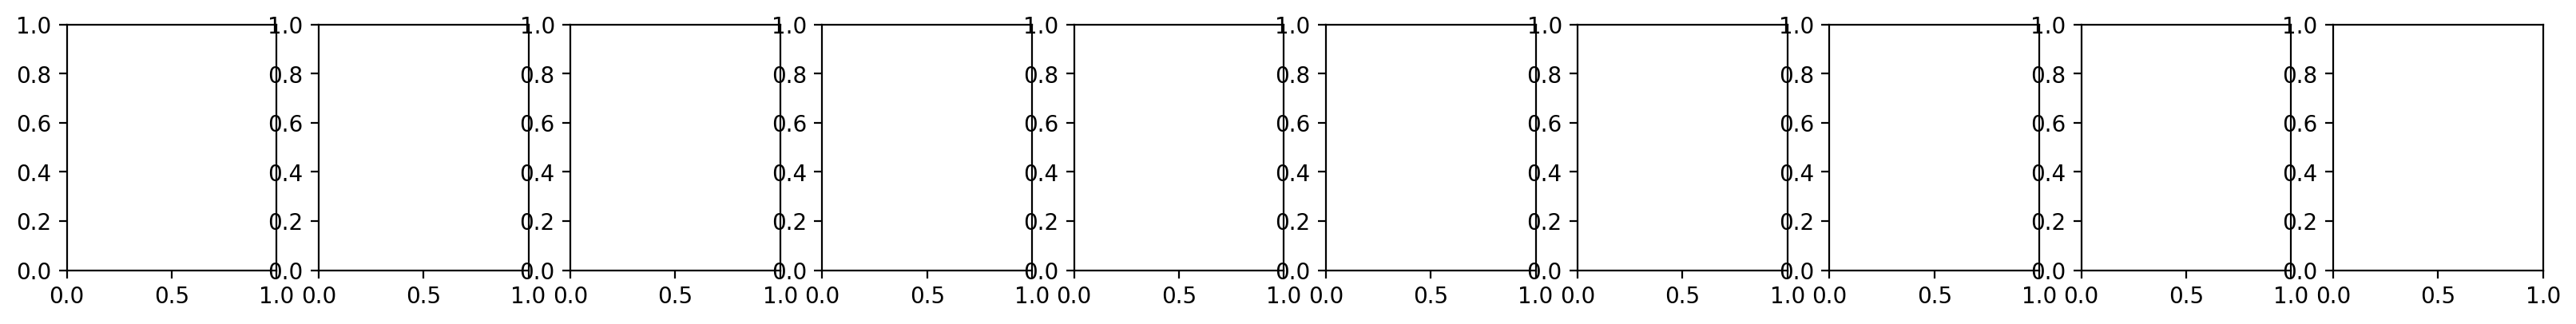

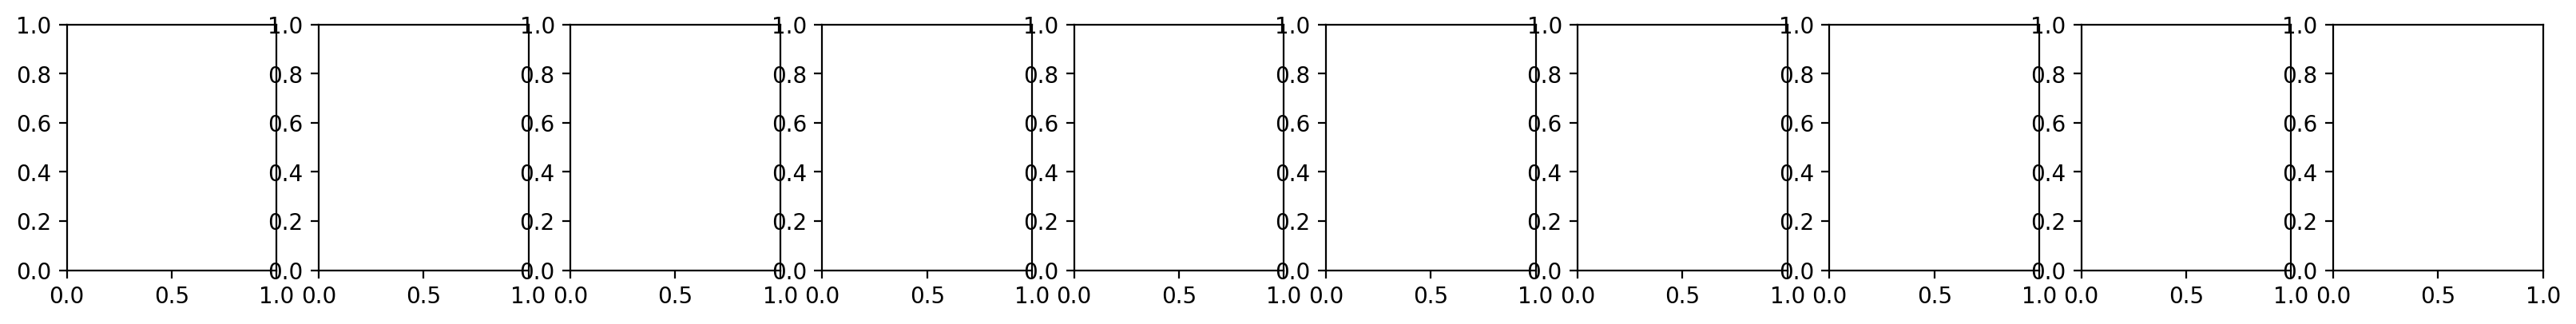

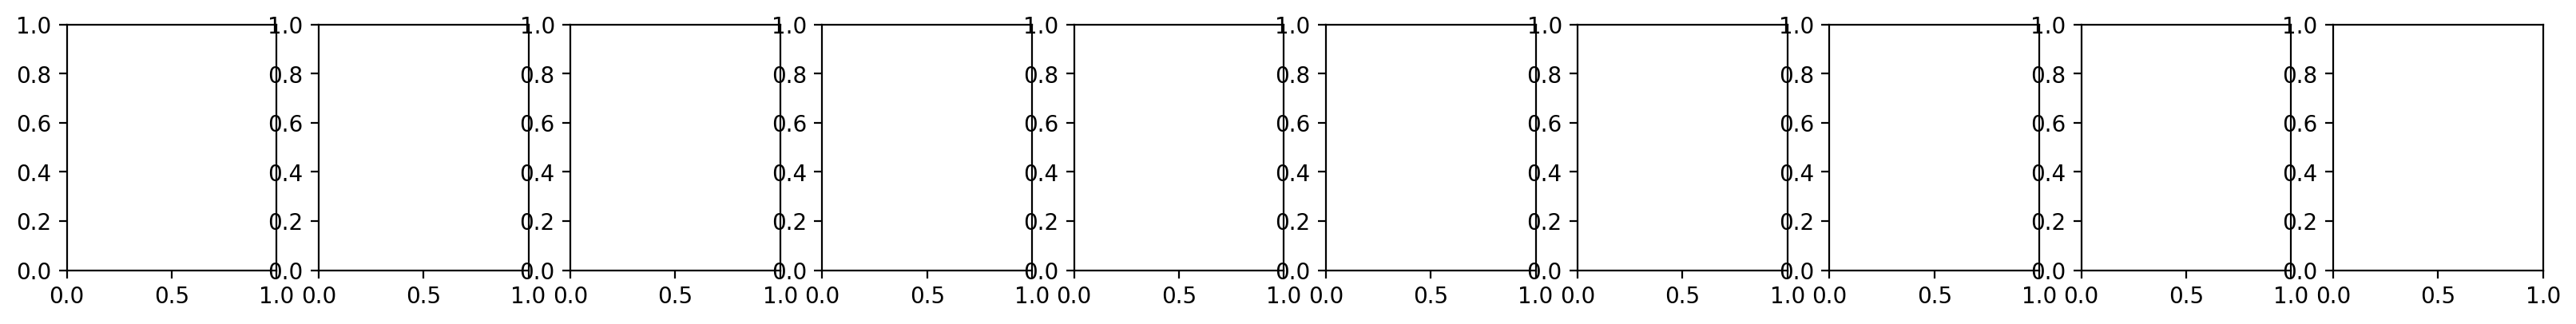

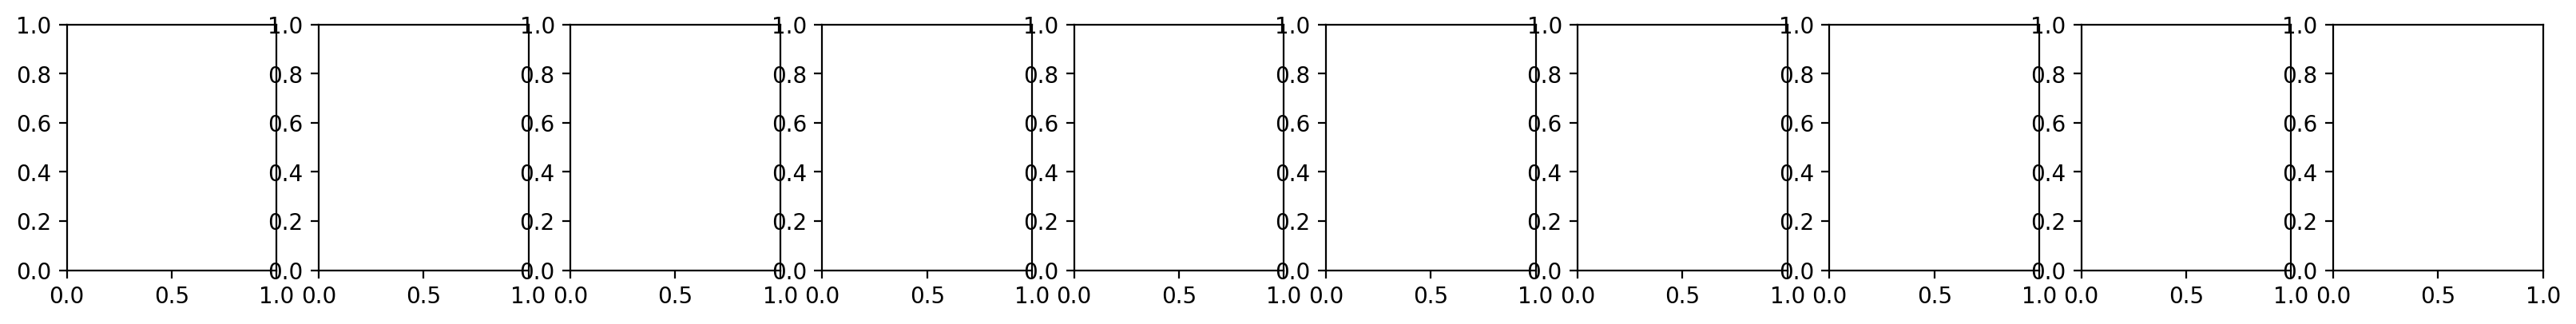

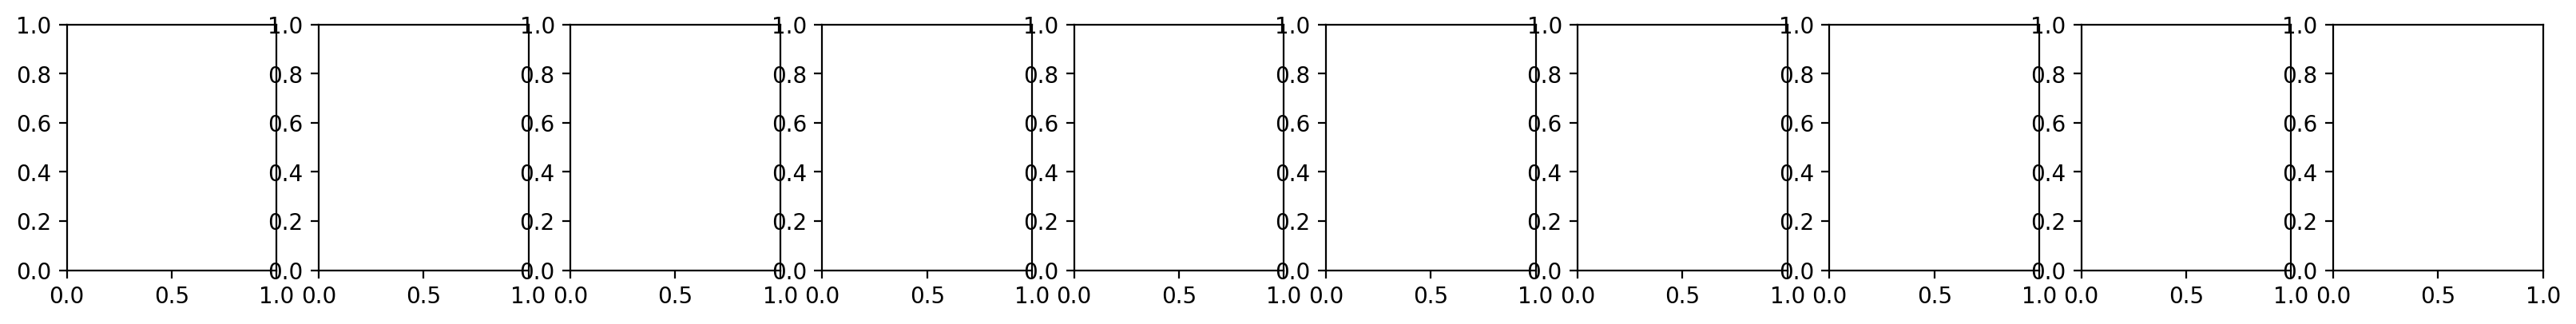

In [53]:
def interpolate_in_batch_and_visualize(vae, batch, idx1, idx2, filename, steps=10):
    """
    Interpolates between two images in a batch in latent space and visualize the morphing sequence.

    Args:
    - vae (nn.Module): The trained VAE model.
    - batch (torch.Tensor): The input batch of images.
    - idx1 (int): Index of the first image in the batch.
    - idx2 (int): Index of the second image in the batch.
    - steps (int): Number of interpolation steps.
    """
    
    # Sample two images from the batch
    img1 = batch[0][idx1:idx1+1].to(device)
    img2 = batch[0][idx2:idx2+1].to(device)

    # Encode images to get latent vectors
    z1, ze1, _ = vae(img1)
    z2, ze2, _ = vae(img2)
    
 # Create an interpolated latent space path
    alphas = np.linspace(0, 1, steps)
    interpolated_latents = [alpha * ze1 + (1 - alpha) * ze2 for alpha in alphas]

    # Ensure that each interpolated latent has the correct shape
#     interpolated_latents = [z.unsqueeze(0) for z in interpolated_latents]

    # Quantize interpolated latents before decoding
    quantized_latents = [vae.codebook(z) for z in interpolated_latents]

    # Decode the interpolated latents
    interpolated_images = [vae.decode(z).detach() for z in quantized_latents]



    # Visualization
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    
    # Visualization and saving
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    for ax, img in zip(axes, interpolated_images):
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)

idx1 = 0  
idx2 = 1  


for i in range(10):
    idx1 = i
    idx2 = i + 1  
    filename = f'vae_output/morph/interpolation_{i}.png'
    interpolate_in_batch_and_visualize(vae, batch, idx1, idx2, filename)

In [70]:
# for i, x in enumerate(data):
#     x = x[0][0:1].to(device)
#     z,z_e_x, z_q_x = vae(x)
#     break

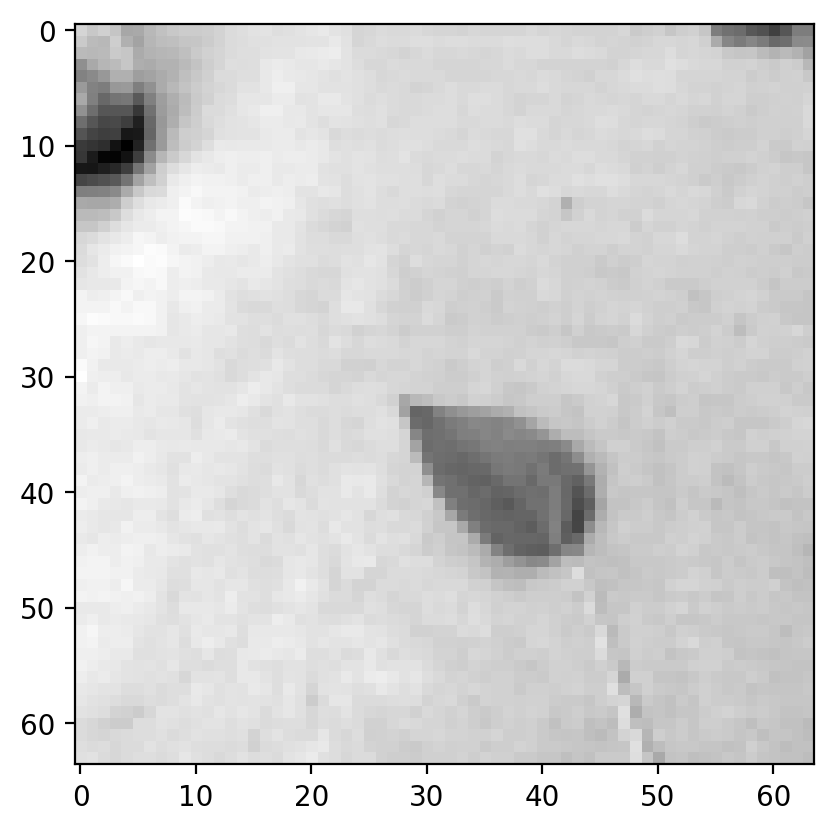

In [73]:
# from PIL import Image
# x1 = x.to('cpu').detach().numpy()
# x2 = np.moveaxis(x1[0], 0, -1)
# imgplot = plt.imshow(x2,cmap='gray')

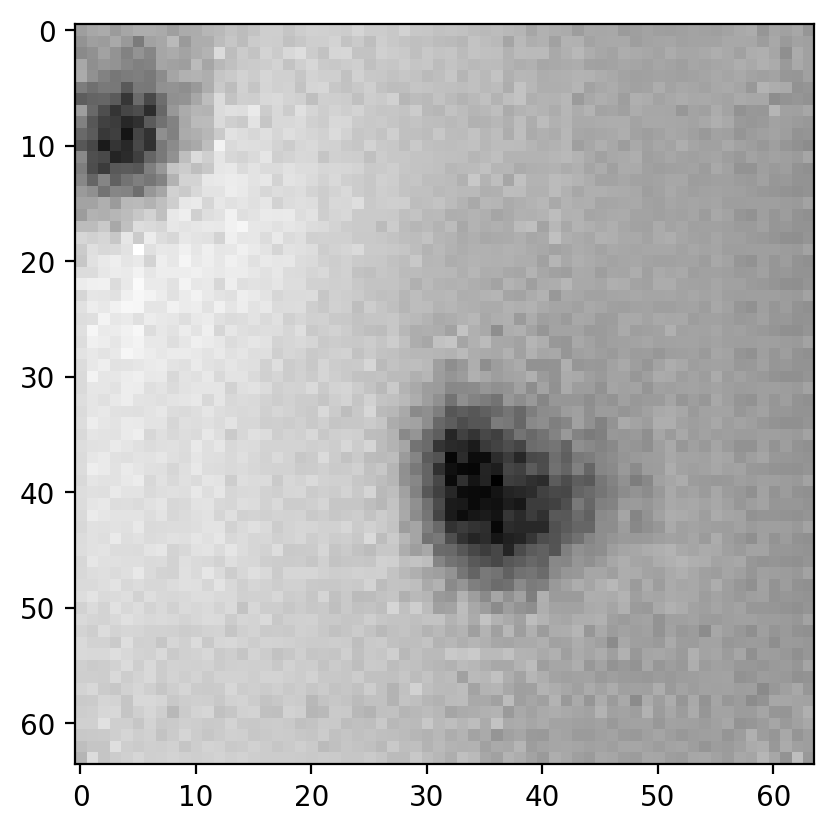

In [74]:
# z1 = z.to('cpu').detach().numpy()
# z2 = np.moveaxis(z1[0], 0, -1)
# imgplot = plt.imshow(z2,cmap='gray')

In [87]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

Let's plot the latent vector representations of a few batches of data.

ValueError: 'c' argument has 200 elements, which is inconsistent with 'x' and 'y' with size 51200.

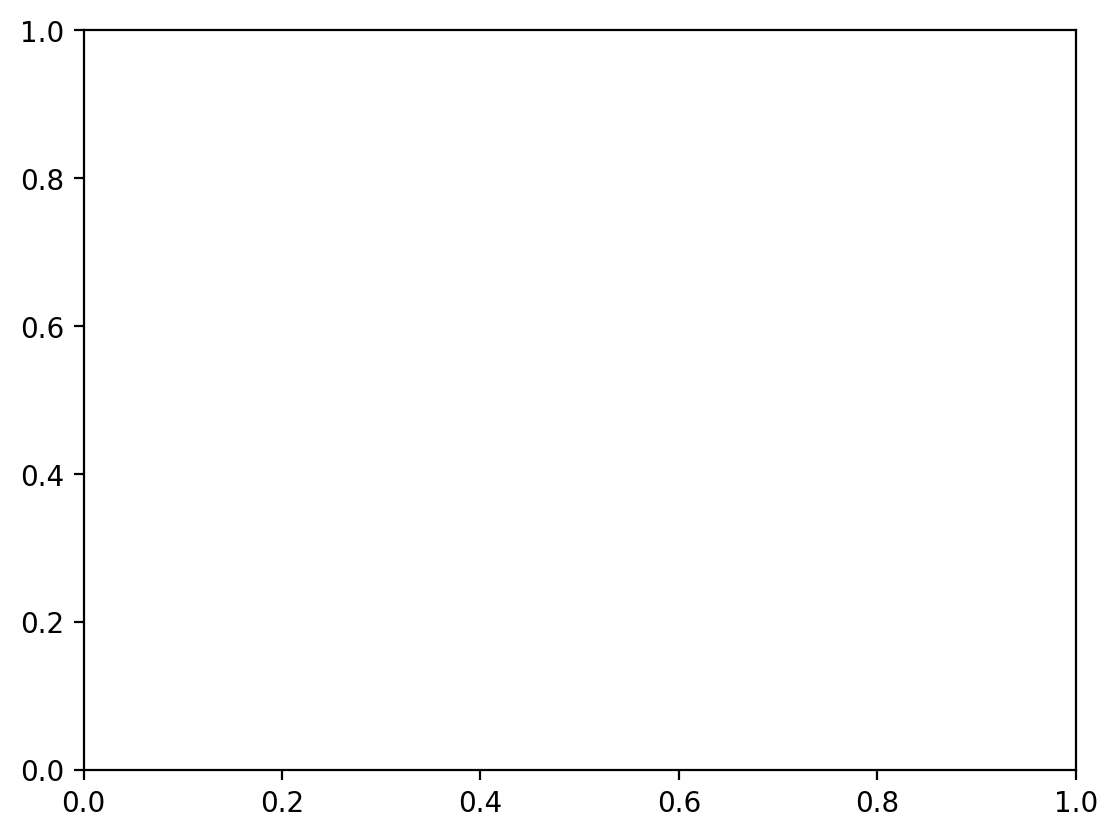

In [88]:
plot_latent(vae, data)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space: